### 1. Import and data loading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time

In [2]:
df = pd.read_csv("../data/chess_games_feature.csv")
df.head()

,WhiteElo,BlackElo,ResultNumeric,EventTypeID,RatingDiff,AvgRating,WhiteIsHigherRated,WhiteRatingAdvantage,ECOID,w_material_early,...,w_castled_early,b_castled_early,w_checks_early,b_checks_early,early_checks,w_piece_activity,b_piece_activity,both_castled_early,total_captures_early,activity_diff
0,2487,2596,1,0,109,2541.5,0,-109,0,20.0,...,1.0,0.0,9.0,2.0,11.0,35.0,37.0,0,15.0,-2.0
1,2542,2433,2,0,109,2487.5,1,109,9,12.0,...,0.0,0.0,1.0,3.0,4.0,25.0,23.0,0,19.0,2.0
2,2404,2534,0,0,130,2469.0,0,-130,0,21.0,...,1.0,1.0,0.0,0.0,0.0,35.0,30.0,1,10.0,5.0
3,2752,2395,2,0,357,2573.5,1,357,0,16.0,...,0.0,1.0,0.0,1.0,1.0,32.0,26.0,0,17.0,6.0
4,2558,2685,2,0,127,2621.5,0,-127,1,28.0,...,1.0,0.0,0.0,0.0,0.0,38.0,33.0,0,9.0,5.0


### 2. Prepare data

In [3]:
X = df.drop(['ResultNumeric'], axis=1)
y = df['ResultNumeric']

print(f"Features: {X.shape}")
print(f"Target: {y.shape}")

Features: (2050967, 33)
Target: (2050967,)


### 3. Train test split

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,        # 20% for testing
    random_state=42,
    stratify=y
)

### 4. Train model

In [5]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1,
    eval_metric='mlogloss'
)

In [6]:
start_time = time.time()

xgb_model.fit(X_train, y_train)

training_time = time.time() - start_time
print(f"Training completed in {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

Training completed in 22.82 seconds (0.38 minutes)


### 5. Evaluate

In [7]:
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"\nTest Set Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Black Win', 'Draw', 'White Win']))


Test Set Accuracy: 0.6319 (63.19%)

Classification Report:

              precision    recall  f1-score   support

   Black Win       0.61      0.70      0.65    164829
        Draw       0.80      0.29      0.43     71268
   White Win       0.63      0.70      0.67    174097

    accuracy                           0.63    410194
   macro avg       0.68      0.57      0.58    410194
weighted avg       0.65      0.63      0.62    410194



### 6. Confusion Matrix

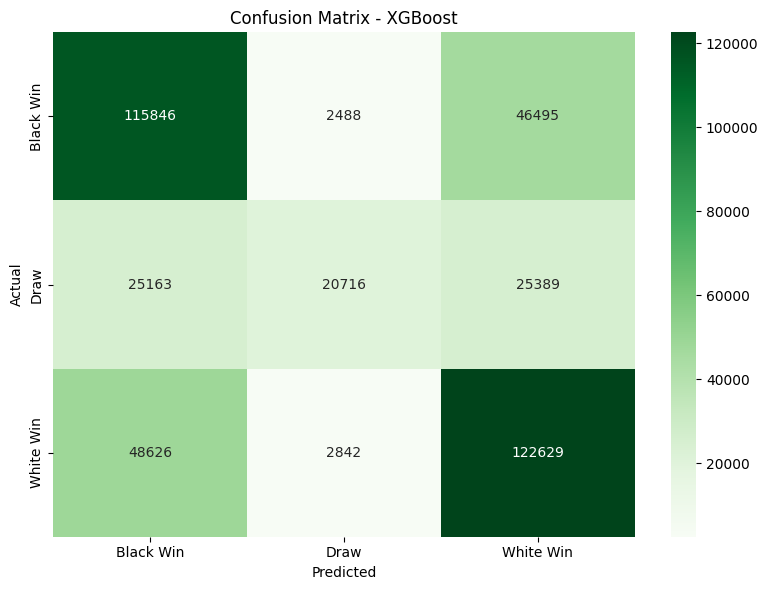

In [8]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Black Win', 'Draw', 'White Win'],
            yticklabels=['Black Win', 'Draw', 'White Win'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - XGBoost')
plt.tight_layout()
plt.show()

### 7. Feature Importance

                  Feature  Importance
5      WhiteIsHigherRated    0.480129
4               AvgRating    0.122261
10    material_diff_early    0.095596
6    WhiteRatingAdvantage    0.051786
0                WhiteElo    0.033527
1                BlackElo    0.028427
3              RatingDiff    0.020863
15     b_aggression_early    0.018174
9        b_material_early    0.017272
32          activity_diff    0.017264
2             EventTypeID    0.015122
21          b_development    0.011246
31   total_captures_early    0.010222
16  aggression_diff_early    0.009246
29       b_piece_activity    0.008987
20          w_development    0.008413
28       w_piece_activity    0.007407
12       b_captures_early    0.005609
13     capture_diff_early    0.005586
22       development_diff    0.004208
8        w_material_early    0.004065
26         b_checks_early    0.004041
11       w_captures_early    0.003577
27           early_checks    0.002390
19            center_diff    0.002135
25         w

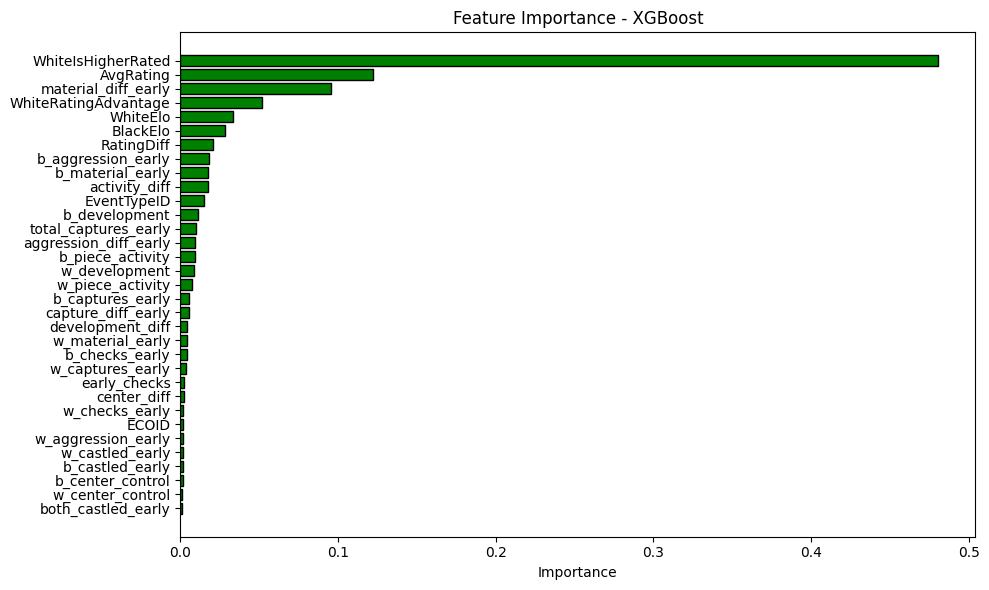

In [9]:
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='green', edgecolor='black')
plt.xlabel('Importance')
plt.title('Feature Importance - XGBoost')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()